# <a id='toc1_'></a>[Ornikar Case Study](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Ornikar Case Study](#toc1_)    
  - [Case study principal](#toc1_1_)    
    - [EDA](#toc1_1_1_)    
      - [Vérifier les doublons](#toc1_1_1_1_)    
      - [Encoding des cibles](#toc1_1_1_2_)    
      - [Contrôle du déséquilibre des cibles](#toc1_1_1_3_)    
    - [Préparation des données](#toc1_1_2_)    
      - [Data types](#toc1_1_2_1_)    
      - [Traitement NaNs](#toc1_1_2_2_)    
      - [Heatmap de corrélation de Spearman](#toc1_1_2_3_)    
      - [Datetime encoding](#toc1_1_2_4_)    
      - [Vérifier les features de variance nulle](#toc1_1_2_5_)    
    - [ML modeling](#toc1_1_3_)    
      - [Baseline](#toc1_1_3_1_)    
        - [Scoring metric](#toc1_1_3_1_1_)    
        - [Ensemble de modèles](#toc1_1_3_1_2_)    
        - [Encoding des features catégoriels et la validation croisée](#toc1_1_3_1_3_)    
      - [Fine-tuning](#toc1_1_3_2_)    
        - [Gérer le déséquilibre des cibles](#toc1_1_3_2_1_)    
        - [Feature importance](#toc1_1_3_2_2_)    
    - [Conclusion](#toc1_1_4_)    
    - [Résultats business](#toc1_1_5_)    
  - [Deux petits casse-têtes](#toc1_2_)    
    - [Présence de graphes au sein d’un dataset](#toc1_2_1_)    
    - [Etudes contradictoires](#toc1_2_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [50]:
%load_ext autoreload
%autoreload 2
import pathlib

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## <a id='toc1_1_'></a>[Case study principal](#toc0_)
Objectif : apprendre à prédire de façon efficace la conversion de nos leads en clients, en un
temps limité, avec les données disponibles.

In [51]:
from src import constants

In [52]:
df_raw = pd.read_csv(pathlib.Path(constants.QUOTES), index_col=0)
df_raw.head(5)

,long_quote_id,lead_id,last_utm_source,has_been_proposed_formulas,has_chosen_formula,has_subscribed_online,submitted_at,effective_start_date,rbs_result,provider,...,main_driver_age,main_driver_gender,main_driver_licence_age,main_driver_bonus,vehicle_age,vehicle_class,vehicle_group,vehicle_region,has_secondary_driver,has_subscribed
0,7527452923606463240,-1065398551916348537,NaN,False,False,False,2021-09-01 18:18:19 UTC,2021-09-05,NaN,NaN,...,40-59,M,15+,064-084,03-05,I-K,31-32,Picardie,False,False
1,2676593580459190130,-3188174584045372774,NaN,False,False,False,2021-09-01 12:29:25 UTC,2021-09-03,NaN,NaN,...,40-59,F,15+,050,10-14,I-K,29-30,Rhone-Alpes,True,False
2,-8181351603970286153,809161028469555575,NaN,False,False,False,2021-09-01 03:52:34 UTC,2021-11-01,NaN,NaN,...,40-59,M,15+,100,00,O-R,35+,Champagne-Ardenne,True,False
3,-764732241225017791,-3998524949057029294,NaN,False,False,False,2021-09-01 13:23:07 UTC,2021-09-12,NaN,NaN,...,21-24,F,03-06,085-099,10-14,O-R,33-34,Haute-Normandie,True,False
4,-6788988993999017586,6417788977143244366,NaN,False,False,False,2021-09-01 12:01:23 UTC,2021-09-30,NaN,NaN,...,21-24,M,00,100,10-14,L-N,31-32,Picardie,False,False


### <a id='toc1_1_1_'></a>[EDA](#toc0_)
#### <a id='toc1_1_1_1_'></a>[Vérifier les doublons](#toc0_)

In [53]:
duplicates = df_raw[df_raw.duplicated(keep=False)]
if duplicates.empty:
    print("No duplicate rows in the data")
else:
    print(f"Total rows with duplicates: {duplicates.shape[0]}")

Total rows with duplicates: 6


In [54]:
duplicates

,long_quote_id,lead_id,last_utm_source,has_been_proposed_formulas,has_chosen_formula,has_subscribed_online,submitted_at,effective_start_date,rbs_result,provider,...,main_driver_age,main_driver_gender,main_driver_licence_age,main_driver_bonus,vehicle_age,vehicle_class,vehicle_group,vehicle_region,has_secondary_driver,has_subscribed
1007,3193278899385012716,7130577887375435202,google,True,False,False,2021-09-01 18:31:38 UTC,2021-09-11,NaN,provider_A,...,18-20,M,00,100,15-19,F-H,27-28,Champagne-Ardenne,False,True
1008,3193278899385012716,7130577887375435202,google,True,False,False,2021-09-01 18:31:38 UTC,2021-09-11,NaN,provider_A,...,18-20,M,00,100,15-19,F-H,27-28,Champagne-Ardenne,False,True
1030,-2567510670073880055,-7260372995289686164,CRM,False,False,False,2021-09-01 20:35:05 UTC,2021-09-09,NaN,NaN,...,18-20,M,01,100,10-14,L-N,33-34,Pays De La Loire,False,True
1031,-2567510670073880055,-7260372995289686164,CRM,False,False,False,2021-09-01 20:35:05 UTC,2021-09-09,NaN,NaN,...,18-20,M,01,100,10-14,L-N,33-34,Pays De La Loire,False,True
1033,-6207503491702107433,-7260372995289686164,CRM,True,False,False,2021-09-01 20:44:29 UTC,2021-09-09,NaN,provider_A,...,18-20,M,01,100,10-14,L-N,33-34,Pays De La Loire,False,True
1034,-6207503491702107433,-7260372995289686164,CRM,True,False,False,2021-09-01 20:44:29 UTC,2021-09-09,NaN,provider_A,...,18-20,M,01,100,10-14,L-N,33-34,Pays De La Loire,False,True


In [55]:
# Keep only the first duplicated row
df = df_raw[~df_raw.duplicated(keep='first')].reset_index(drop=True)

#### <a id='toc1_1_1_2_'></a>[Encoding des cibles](#toc0_)

In [56]:
df["has_subscribed"] = df["has_subscribed"].astype(int)

#### <a id='toc1_1_1_3_'></a>[Contrôle du déséquilibre des cibles](#toc0_)

In [57]:
pd.concat([df["has_subscribed"].value_counts(normalize=True)*100,
           df["has_subscribed"].value_counts()],
          axis=1,
          keys=('perc','count'))

,perc,count
0,92.656766,1123
1,7.343234,89


❗ L'ensemble de données contient des targets déséquilibrés. Les techniques de traitement du déséquilibre doivent être appliquées pour la modélisation.

### <a id='toc1_1_2_'></a>[Préparation des données](#toc0_)
#### <a id='toc1_1_2_1_'></a>[Data types](#toc0_)

Tout d'abord, nous allons définir visuellement les types de données des colonnes.

In [58]:
df.iloc[:3, :len(df.columns)//2]

,long_quote_id,lead_id,last_utm_source,has_been_proposed_formulas,has_chosen_formula,has_subscribed_online,submitted_at,effective_start_date,rbs_result,provider,product_third_party,product_intermediate,product_all_risks,annual_price_third_party,annual_price_intermediate
0,7527452923606463240,-1065398551916348537,NaN,False,False,False,2021-09-01 18:18:19 UTC,2021-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2676593580459190130,-3188174584045372774,NaN,False,False,False,2021-09-01 12:29:25 UTC,2021-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-8181351603970286153,809161028469555575,NaN,False,False,False,2021-09-01 03:52:34 UTC,2021-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
df.iloc[:3, len(df.columns)//2:]

,annual_price_all_risks,chosen_formula,chosen_product,policy_subscribed_at,contract_id,payment_frequency,main_driver_age,main_driver_gender,main_driver_licence_age,main_driver_bonus,vehicle_age,vehicle_class,vehicle_group,vehicle_region,has_secondary_driver,has_subscribed
0,NaN,NaN,NaN,NaN,NaN,NaN,40-59,M,15+,064-084,03-05,I-K,31-32,Picardie,False,0
1,NaN,NaN,NaN,NaN,NaN,NaN,40-59,F,15+,050,10-14,I-K,29-30,Rhone-Alpes,True,0
2,NaN,NaN,NaN,NaN,NaN,NaN,40-59,M,15+,100,00,O-R,35+,Champagne-Ardenne,True,0


In [60]:
# According to the visual view
cat_features = ['long_quote_id',
                'lead_id',
                'main_driver_age',
                'main_driver_gender',
                'main_driver_licence_age',
                'main_driver_bonus',
                'vehicle_age',
                'vehicle_class',
                'vehicle_group',
                'vehicle_region',]

bool_features = ['has_been_proposed_formulas',
                 'has_chosen_formula',
                 'has_subscribed_online',
                 'has_secondary_driver',]

datetime_features = ['submitted_at',
                     'effective_start_date',]

Pour le reste, les colonnes avec moins de 10 valeurs uniques seront définies comme catégorielles.

**Vérifions les colonnes avec plus de 10 valeurs uniques**

In [61]:
df_rest = df.drop(cat_features + bool_features + datetime_features, axis=1)
df_rest[df_rest.columns[df_rest.nunique() > 10]]

,last_utm_source,product_third_party,product_intermediate,product_all_risks,chosen_product,policy_subscribed_at,contract_id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1207,comparator_C,third_party_product_11,intermdiate_product_6,all_risks_product_1,third_party_product_11,NaN,NaN
1208,comparator_A,NaN,NaN,NaN,NaN,NaN,NaN
1209,comparator_A,NaN,NaN,NaN,NaN,NaN,NaN
1210,comparator_A,third_party_product_4,intermdiate_product_5,all_risks_product_5,intermdiate_product_5,NaN,NaN


❗ La colonne `'policy_subscribed_at'` est datetime. Toutes les autres sont catégorielles.

In [62]:
datetime_features.extend(['policy_subscribed_at'])
residual_cat_cols = [col for col in df.columns if col not in (cat_features + bool_features + datetime_features + ['has_subscribed'])]
cat_features.extend(residual_cat_cols)

In [63]:
from src.data_prep import feature_transform

In [64]:
df_transformed = feature_transform.set_dtypes(df,
                                              cat_cols=cat_features,
                                              bool_cols=bool_features,
                                              datetime_cols=datetime_features)

In [65]:
df_transformed.dtypes

long_quote_id                              object
lead_id                                    object
last_utm_source                            object
has_been_proposed_formulas                   bool
has_chosen_formula                           bool
has_subscribed_online                        bool
submitted_at                  datetime64[ns, UTC]
effective_start_date          datetime64[ns, UTC]
rbs_result                                 object
provider                                   object
product_third_party                        object
product_intermediate                       object
product_all_risks                          object
annual_price_third_party                   object
annual_price_intermediate                  object
annual_price_all_risks                     object
chosen_formula                             object
chosen_product                             object
policy_subscribed_at          datetime64[ns, UTC]
contract_id                                object


La colonne `'has_subscribed_online'` ressemble à un feature lié au target

In [66]:
df_transformed[['has_subscribed_online', 'has_subscribed']].value_counts().to_frame(name='counts')

counts
has_subscribed_online has_subscribed        
False                 0                 1123
                      1                   72
True                  1                   17

❗ Tous les utilisateurs `'has_subscribed_online'` positifs ont souscrit un contrat. Il s'agit d'un feature lié à la cible (ne sera pas disponible pour l'inférence). Il devrait être supprimé.

In [67]:
df_transformed.drop('has_subscribed_online', axis=1, inplace=True)

#### <a id='toc1_1_2_2_'></a>[Traitement NaNs](#toc0_)

In [68]:
df_nans = pd.DataFrame((df.isna().mean()*100).sort_values(ascending=False)).rename(columns={0: '%_NaNs'})

In [69]:
px.scatter(df_nans,
           x=df_nans.index,
           y="%_NaNs",
           title="Count of NaNs in data",
           ).update_layout(
               xaxis_title="Sensor number",
               yaxis_title="% of NaNs")

Pipeline de traitement NaN :
1. Drop les colonnes 100% NaN
2. Remplacez NaN par 'not_provided' pour les colonnes catégorielles
3. Transformez la colonne datetime `'policy_subscribed_at'` en binaire (valeur présente/non)
4. Imputer la colonne datetime `'effective_start_date'`. Mettre la distance médiane entre `'submitted_at'` et la `'effective_start_date'` du dataset complet.

In [70]:
# Drop cols with 100% of NaNs
df_transformed.dropna(axis=1, how='all', inplace=True)

In [71]:
# NaN -> not_provided in cat cols
df_transformed = feature_transform.slice_nan_imputer(df_transformed,
                                                     list_cols=df_transformed.select_dtypes(include=object).columns,
                                                     string='not_provided')

In [72]:
# Binarize the `policy_subscribed_at` column
df_transformed = feature_transform.col_binarize(df_transformed,
                                                list_cols=['policy_subscribed_at'],)

In [73]:
# Imputation of the `effective_start_date` column
df_transformed = feature_transform.esd_imputer(df_transformed)

In [74]:
# Verify the nans
df_transformed.isna().sum().sum()

0

#### <a id='toc1_1_2_3_'></a>[Heatmap de corrélation de Spearman](#toc0_)

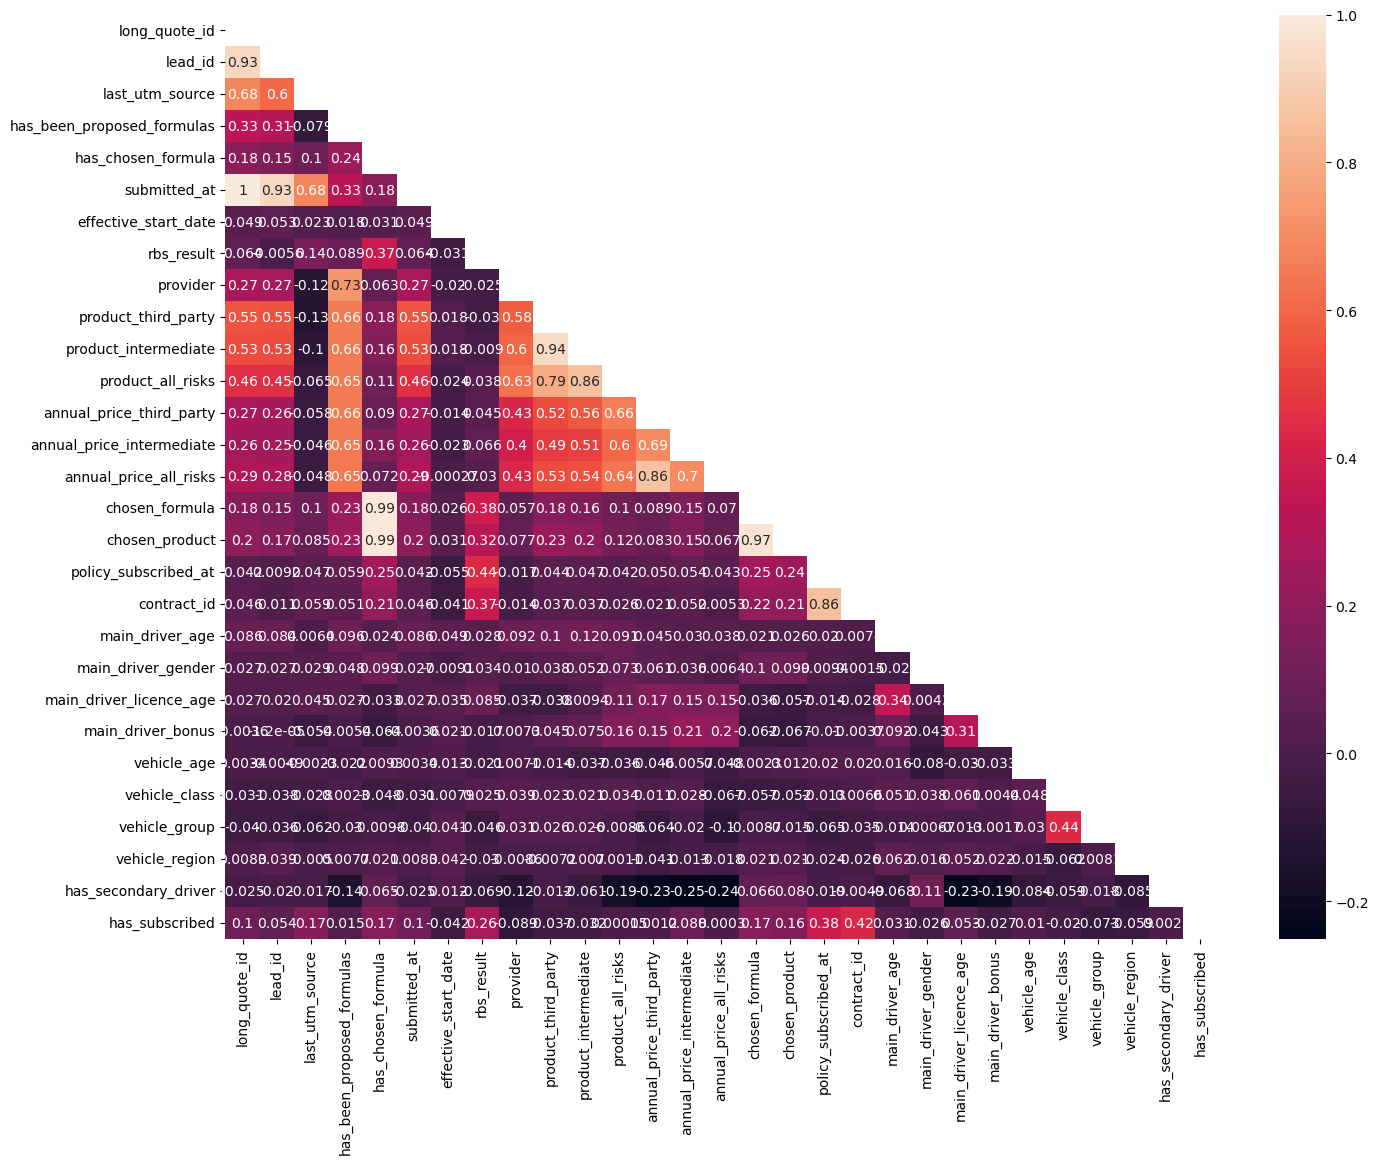

In [75]:
corr = df_transformed.apply(lambda x : pd.factorize(x)[0]).corr(method='spearman', min_periods=1) # factorize cat features, use the spearman rank correlation
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, mask=np.triu(corr));

In [76]:
# Visualize high correlating features
from src.data_viz import viz_funcs

viz_funcs.corr_viz(corr, threshold=0.85)

,,Pearson corr coef
long_quote_id,submitted_at,1.000000
chosen_formula,has_chosen_formula,0.989650
has_chosen_formula,chosen_product,0.988354
chosen_product,chosen_formula,0.972626
product_third_party,product_intermediate,0.942013
submitted_at,lead_id,0.931980
annual_price_all_risks,annual_price_third_party,0.864464
policy_subscribed_at,contract_id,0.857538
product_all_risks,product_intermediate,0.855488


In [77]:
df_transformed[['long_quote_id', 'submitted_at']].nunique()

long_quote_id    1212
submitted_at     1212
dtype: int64

❗ Certaines insights business peuvent être déduits. La corrélation entre `'long_quote_id'` et `'submitted_at'` est liée à l'unicité de ces colonnes. Certains modèles ML peuvent être sensibles à la multicolinéarité. Nous appliquerons des algorithmes tolérants à la multicolinéarité et des méthodes de régularisation pour gérer cela.

#### <a id='toc1_1_2_4_'></a>[Datetime encoding](#toc0_)

Afin d'utiliser les informations des colonnes datetime, le pipeline suivant pour l'encodage datetime sera appliqué :
1. Extraire l'année en tant que valeur int
2. Extraire le nom du mois en tant que valeur catégoriel
3. Extraire le jour comme valeur int
4. Si le temps est fourni, ajouter le sinus et le cosinus du temps comme des nouveaux features.

In [78]:
df_transformed = feature_transform.datetime_encoding(df_transformed)

#### <a id='toc1_1_2_5_'></a>[Vérifier les features de variance nulle](#toc0_)

In [79]:
zero_var_cols = df_transformed.var()[df_transformed.var() == 0].index
zero_var_cols

Index(['submitted_at_year', 'submitted_at_day', 'effective_start_date_year'], dtype='object')

❗ Dropping 0-vav columns

In [80]:
df_transformed.drop(zero_var_cols, axis=1, inplace=True)

### <a id='toc1_1_3_'></a>[ML modeling](#toc0_)
#### <a id='toc1_1_3_1_'></a>[Baseline](#toc0_)
##### <a id='toc1_1_3_1_1_'></a>[Scoring metric](#toc0_)

Il existe un ensemble de métriques ML pour les problèmes de classification binaire, basées sur les combinaisons des prédictions TP, TN, FN et FP.
 
**Precision** calcule le rapport entre les vrais positifs et le total des positifs prédits par un classifieur.

True positive rate, aka **Recall**, nous donne le nombre de vrais positifs divisé par le nombre total d'éléments qui appartiennent réellement à la classe positive.

Dans notre cas, le **Recall** est une mesure plus importante que la **Precision** étant donné que nous sommes plus préoccupés par les faux négatifs (notre modèle prédit que quelqu'un ne va pas signer le contrat, mais ils le font) que par les faux positifs (notre modèle prédit que quelqu'un va signer le contrat mais ils ne le font pas).

Cependant, parfois (et c'est le cas de cette étude) l'utilisation du **Recall** comme métrique d'évaluation pour la validation croisée conduit à un overfitting sur les données train et à une faible généralisation du modèle.

Pour y faire face, nous allons utiliser le **ROC AUC score** qui prend en compte à la fois le **Recall** et le **Fall-out (False Positive Rate)**. Un modèle avec une capacité de discrimination élevée aura simultanément un TPR et un FPR élevés.

--------------------

    ❗ Solution optimale : avec les coûts business estimatifs des prédictions TP, FP et FN, un scoreur d'évaluation personnalisée pourrait être mis en œuvre. Cette métrique personnalisée peut prendre en compte les pertes dans les cas FN et FP et les gains dans les cas TP. En combinant ces estimations, un modèle pourrait optimiser le revenu total en adaptant le seuil de discrimination.

##### <a id='toc1_1_3_1_2_'></a>[Ensemble de modèles](#toc0_)
Les modèles ML suivants vont être testés de base:

    1. SVM avec noyau polynomial
    2. SVM avec noyau rbf
    3. Logistic Regression
    4. KNeighbors Classifier
    5. Random Forest Classifier
    6. LGBM Classifier

L'idée est de tester des modèles tolérants au réglage fin et de nature différente.

##### <a id='toc1_1_3_1_3_'></a>[Encoding des features catégoriels et la validation croisée](#toc0_)

Nous allons appliquer l'encodeur Helmert contrast aux features catégoriels du dataset actuel. L'encodeur Helmert compare les niveaux d'une variable avec la moyenne des niveaux suivants de cette variable.

De plus, nous allons utiliser une fonction de validation croisée personnalisée pour la modélisation de base afin d'implémenter l'encoding catégoriel avec une seule étape de validation (les features catégoriels sont encodées sur le dataset test pour chaque split et les scores sont calculés comme moyenne pour chaque modèle).

In [81]:
from sklearn.metrics import roc_auc_score, recall_score
from src.estimation import baseline_test

In [82]:
estimators_w_sclng = baseline_test.baseline(df_transformed.drop('has_subscribed', axis=1),
                                   df_transformed['has_subscribed'],
                                   est_list=constants.PP_W_SCLNG,
                                   shuffle=True,
                                   random_state=constants.RND_SEED,
                                   scoring=roc_auc_score)

estimators_wo_sclng = baseline_test.baseline(df_transformed.drop('has_subscribed', axis=1),
                                   df_transformed['has_subscribed'],
                                   est_list=constants.PP_WO_SCLNG,
                                   shuffle=True,
                                   random_state=constants.RND_SEED,
                                   scoring=roc_auc_score)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [83]:
estimators_w_sclng, estimators_wo_sclng

({'SVC-poly': 0.5,
  'SVC-rbf': 0.5840996168582375,
  'LogisticRegression': 0.6063218390804598,
  'KNeighborsClassifier': 0.7023624070317783},
 {'RandomForestClassifier': 0.6452583031122585,
  'LGBMClassifier': 0.714057614686418})

❗ LGBM gradient booster est notre solution à fine-tune

#### <a id='toc1_1_3_2_'></a>[Fine-tuning](#toc0_)

In [84]:
from sklearn.model_selection import train_test_split
from category_encoders.helmert import HelmertEncoder

##### <a id='toc1_1_3_2_1_'></a>[Gérer le déséquilibre des cibles](#toc0_)

Il existe plusieurs méthodes pour gérer le déséquilibre des données :
1. Suréchantillonnage de la classe minoritaire
2. Sous-échantillonnage de la classe majoritaire
3. Pénaliser l'algorithme ML

Selon les conclusions des résultats de base, nous allons sélectionner le modèle de gradient booster, dans l'implémentation LightGBM de Microsoft.
Cet algorithme contient une méthode simple pour pénaliser les classes lors de l'entraînement. Ainsi, la 3ème approche de gestion du déséquilibre sera choisie.

In [85]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(df_transformed.drop('has_subscribed', axis=1),
                                                    df_transformed['has_subscribed'],
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    stratify=df_transformed['has_subscribed'],
                                                    random_state=constants.RND_SEED)

In [86]:
cat_features = list(X_train_raw.select_dtypes(include=[object]).columns)
helm_encoder = HelmertEncoder(cols=cat_features)

X_train = helm_encoder.fit_transform(X_train_raw, y_train)
X_test = helm_encoder.transform(X_test_raw)

In [87]:
from lightgbm import LGBMClassifier
from optuna.integration import OptunaSearchCV

scaling_weight = round(df_transformed['has_subscribed'].value_counts()[0]/df_transformed['has_subscribed'].value_counts()[1])
clf = LGBMClassifier(scale_pos_weight=scaling_weight,
                     random_state=constants.RND_SEED,
                     verbose=-1)

gs = OptunaSearchCV(clf,
                    constants.OPT_HYPER_PARAMS,
                    random_state=constants.RND_SEED,
                    scoring='roc_auc',
                    n_trials=45,
                    timeout=None,)

In [88]:
gs.fit(X_train, y_train)

[I 2023-02-26 17:15:20,033] A new study created in memory with name: no-name-7595ecc2-d1e5-4e57-95b7-1e9f5eb157e2
[I 2023-02-26 17:15:22,172] Trial 0 finished with value: 0.8509890574345349 and parameters: {'learning_rate': 0.018771771586358836, 'max_depth': 7, 'n_estimators': 25}. Best is trial 0 with value: 0.8509890574345349.
[I 2023-02-26 17:15:24,396] Trial 1 finished with value: 0.8690298729869734 and parameters: {'learning_rate': 0.003955817571114231, 'max_depth': 4, 'n_estimators': 82}. Best is trial 1 with value: 0.8690298729869734.
[I 2023-02-26 17:15:26,185] Trial 2 finished with value: 0.7805355710786819 and parameters: {'learning_rate': 0.0011538022192661734, 'max_depth': 2, 'n_estimators': 51}. Best is trial 1 with value: 0.8690298729869734.
[I 2023-02-26 17:15:29,231] Trial 3 finished with value: 0.8742142965515747 and parameters: {'learning_rate': 0.003914949966612523, 'max_depth': 3, 'n_estimators': 256}. Best is trial 3 with value: 0.8742142965515747.
[I 2023-02-26 17

OptunaSearchCV(estimator=LGBMClassifier(random_state=42, scale_pos_weight=13,
                                        verbose=-1),
               n_trials=45,
               param_distributions={'learning_rate': FloatDistribution(high=10.0, log=True, low=0.0001, step=None),
                                    'max_depth': IntDistribution(high=8, log=False, low=1, step=1),
                                    'n_estimators': IntDistribution(high=256, log=False, low=8, step=1)},
               random_state=42, scoring='roc_auc')

In [89]:
lgbm = gs.predict(X_test)

In [90]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, f1_score

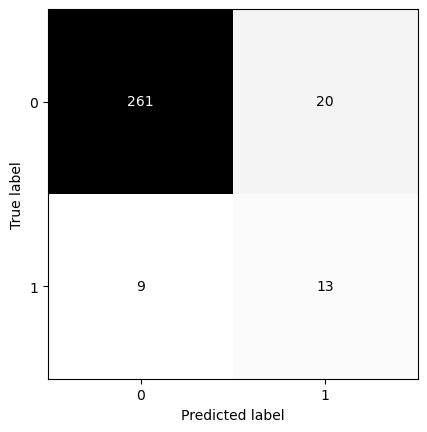

In [91]:
# Visualize the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, lgbm, cmap='binary', colorbar=False)
plt.grid(False)

In [92]:
tuned_roc_auc = roc_auc_score(y_test, lgbm)
tuned_recall = recall_score(y_test, lgbm)
tuned_f1 = f1_score(y_test, lgbm)
print(f"The recall test score of the tuned LGBM classifier is: {tuned_recall:.3f}")
print('-------------------------------------------------------------')
print(f"The ROC AUC test score of the tuned LGBM classifier is: {tuned_roc_auc:.3f}")
print(f"The f1 test score of the tuned LGBM classifier is: {tuned_f1:.3f}")

The recall test score of the tuned LGBM classifier is: 0.591
-------------------------------------------------------------
The ROC AUC test score of the tuned LGBM classifier is: 0.760
The f1 test score of the tuned LGBM classifier is: 0.473


##### <a id='toc1_1_3_2_2_'></a>[Feature importance](#toc0_)

Comme le dataframe d'origine a été encodée avec l'encodeur Helmert, j'ai créé une fonction de traçage personnalisée de l'importance des features, qui additionne l'importance des features encodés pour représenter les colonnes d'origine.

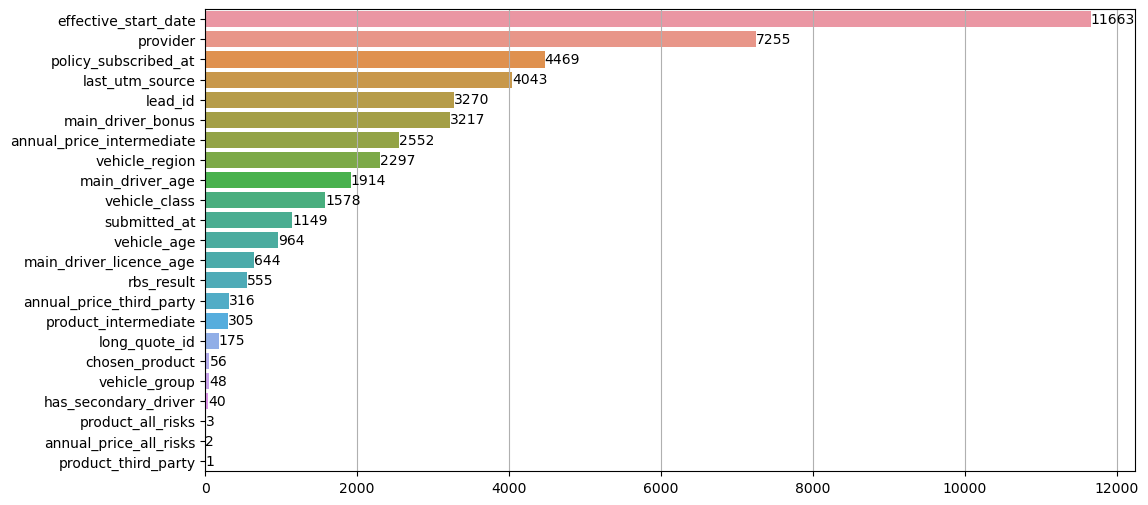

In [93]:
viz_funcs.custom_feature_imp_plot(gs.best_estimator_,
                                  importance_type='gain',
                                  default_cols=df.columns,
                                  encoded_cols=X_train.columns,
                                  figsize=(12, 6),);

### <a id='toc1_1_4_'></a>[Conclusion](#toc0_)
- *ROC AUC score* est sélectionné comme métrique d'évaluation optimale.
- Cinq différents types de modèles ML ont été testés pour la prédiction de base.
- **Helmert** encodeur a été utilisé pour l'encodage des features catégoriels.
- Chaque modèle de base a été validé avec une fonction cv personnalisée. L'ensemble de test de chaque split contenait ses propres features catégoriels encodés par **Helmert**.
- Gradient boosted ensembles of trees montre un meilleur résultat par rapport à d'autres modèles.
- L'optimisation bayésienne des hyperparamètres a permis d'obtenir le *Recall* de **0,591**.


### <a id='toc1_1_5_'></a>[Résultats business](#toc0_)

- Le *Recall* de **0,591** signifie qu'environ 59% des prospects susceptibles de signer un contrat peuvent être prédits par le modèle.
- Selon feature importance, le feature `effective_start_date` est prédominant en matière de prédiction, 3 autres features importants sont :

        provider
        policy_subscribed_at
        last_utm_source

## <a id='toc1_2_'></a>[Deux petits casse-têtes](#toc0_)
### <a id='toc1_2_1_'></a>[Présence de graphes au sein d’un dataset](#toc0_)
Mon idée:
1. Ajouter `'family'` cat feature
2. Ajoutez `'family_member_canceled'` cat feature
2. Le leakadge cible doit être exclu, de sorte que la méthode de validation croisée StratifiedGroupKFold peut être optimale. Chaque groupe ne sera pas divisé entre les sets de test et de train.
3. La régularisation est utilisée pour éviter l'over-fitting des modèles. Cela peut augmenter la généralisation, mais ce n'est pas garanti.

### <a id='toc1_2_2_'></a>[Etudes contradictoires](#toc0_)

C'est le [Paradoxe de Simpson](https://en.wikipedia.org/wiki/Simpson%27s_paradox), un phénomène en statistique quand, en présence de deux groupes de données, dans chacun desquels il y a une dépendance également dirigée, lorsque ces groupes sont combinés, le sens de la dépendance est inversé.

On suppose intuitivement que s'il existe une dépendance dans les deux groupes, elle devrait également apparaître lorsque ces groupes sont combinés. Mais en raison de la non-représentativité du groupe témoin dans les données agrégées, cette tendance ne persiste pas.

Pour un calcul correct de la moyenne (étude A dans notre cas), il faut s'assurer de la représentativité du groupe témoin dans les deux échantillons en introduisant des coefficients de pondération afin que la proportion pondérée de témoins dans les deux groupes devienne la même.

In [94]:
prop_gross = (331 + 564) / (90 + 92)
prop_pet = (11 + 94)  / (147 + 671)
coef = prop_gross / prop_pet
coef

38.31030873888017

In [95]:
# Drug treatment % of recovery
761/(239+761)

0.761

In [96]:
# Surgery treatment, weighted % of recovery
(564 + 94*coef) / ((331 + 11*coef) + (564 + 94*coef))

0.846995264698058